# Wyżarzacze kwantowe

Wyżarzaczem kwantowym nazywamy maszynę która fizycznie implementuje algorytm wyżarzania kwantowego. Obecnie najpopularniejsze są urządzenia produkowane przez firmę DWave. W sercu każdej maszyny leży procesor kwantowy, *Quantum Proccesing Unit* (QPU), składający się z kubitów połączonych couplerami (czasami słowo *coupler* tłumaczy się jako "sprzęgacz"). W tym szkoleniu nie będziemy wdawać się w szczegóły jak te kubity i couplery fizycznie wyglądają. Strukturę połączeń między kubitami w QPU nazywamy **topologią**.  

## Topologie procesorów DWave

### Chimera

Jest to pierwsza i najstarsza z istniejących topologii. Składa się z komórek jednostkowych (ang. *Unit Cell*) połączonych ze sobą w kształt kraty. Każda z komórek składa się z ośmiu kubitów połączonych ze sobą jak pełny graf dwudzielny $K_{4, 4}$. Poniżej jest przedstawiony przykład Chimery **C2**

<img src="pictures/chimera.png" width="700" height="700" />

### Pegasus

Jest to obecnie standardowa topologia używana w wyżarzaczach D-Wave. Nie ma najprostrzej konstrukcji.

![image](pictures/pegasus.png)

WIP, jak zawsze problem ze śmiecami na brzegach. Dodam ilustracje bez nich z dopiskiem że tak wyglądają standardowe instancje które używamy

### Zephyr

Najnowocześniejsza topologia. Urządzenia które ją implementują są obecnie w fazie prototypów. **Z2** czyli zephyr złorzony z 2x2 komórek jednostkowych. Na pierwszy rzut oka widać zarówno więcej kubitów jak i znacznie gęściejszą siatkę połączeń.


![image](pictures/zephyr.png)

## Embedding

Z powodu tego jak jest skonstuowana sieć połączeń w QPU, wiele problemów trzeba osadzić w grafie topologii QPU.

TODO: Opisz koncept łańcuchów

Znaleziono osadzenie:
  K3 wierzchołek 0 -> wierzchołek 6
  K3 wierzchołek 1 -> łańcuch [0, 5]
  K3 wierzchołek 2 -> wierzchołek 2


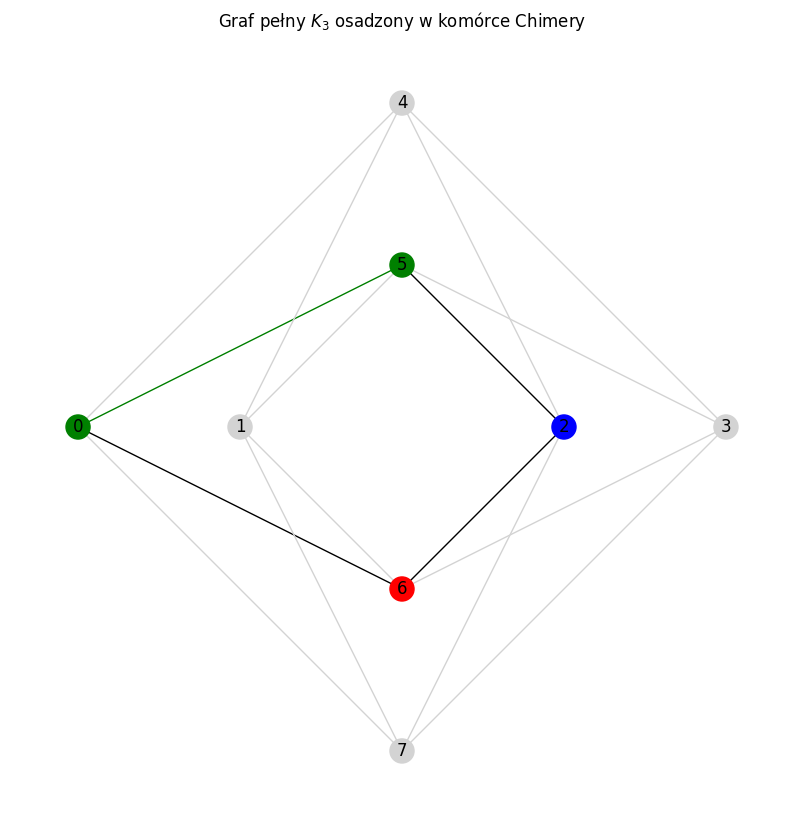

In [44]:
import networkx as nx
import dwave_networkx as dnx
import minorminer
import matplotlib.pyplot as plt


chimera = dnx.chimera_graph(1, 1, 4)  # pojedyńcza komórka chimery
K3 = nx.complete_graph(3)

# Automatyczne szukanie osadzenia
embedding = minorminer.find_embedding(K3, chimera)
print("Znaleziono osadzenie:")
for k3_node, chain in embedding.items():
    if len(chain) > 1:
        print(f"  K3 wierzchołek {k3_node} -> łańcuch {chain}")
    else:
        print(f"  K3 wierzchołek {k3_node} -> wierzchołek {chain[0]}")



chain_colors = {k: color for k, color in zip(embedding.keys(), ["red", "green", "blue", "purple"])}

# Budujemy mapę kolorów dla komórki chimery
node_color = {}
edge_color = {}

for k3_node, chain in embedding.items():
    for q in chain:
        node_color[q] = chain_colors[k3_node]
    if len(chain) > 1:
        v, w = chain
        edge_color[(v, w)] = chain_colors[k3_node]
        edge_color[(w, v)] = chain_colors[k3_node]

for (v, w) in K3.edges():
    x = embedding[v]
    y = embedding[w]
    if len(x) == len(y) == 1:
        edge_color[(x[0], y[0])] = "black"
        edge_color[(y[0], x[0])] = "black"
    elif len(x) > 1:
        edge_color[(x[0], y[0])] = "black"
        edge_color[(y[0], x[0])] = "black"
        edge_color[(x[1], y[0])] = "black"
        edge_color[(y[0], x[1])] = "black"
    else:
        edge_color[(x[0], y[0])] = "black"
        edge_color[(y[0], x[0])] = "black"
        edge_color[(x[0], y[1])] = "black"
        edge_color[(y[1], x[0])] = "black"
    
# TODO: napisz lepiej
    
    


# Kolor dla kubitów i krawędzi nie używanych w embeddingu
default_color = "lightgray"

node_colors = [node_color.get(node, default_color) for node in chimera.nodes()]
edge_colors = [edge_color.get(edge, default_color) for edge in chimera.edges()]


plt.figure(figsize=(8, 8))
dnx.draw_chimera(chimera, node_color=node_colors, edge_color=edge_colors, with_labels=True, node_size=300)
plt.title(rf"Graf pełny $K_3$ osadzony w komórce Chimery")
plt.show()

w powyższym obrazku czarne krawędzie oznaczają krawędzie w oryginalnym grafiem a krawędzie w kolorze wierzchołków oznaczają łańcuch.

### Większy przykład na prawdziwej architekturze
Najpierw trzeba klikną "Source - QPU", a następnie po lewej stronie "show chains" oraz "show broken chains

In [3]:
# dokładnie co się dzieje w kodzie będzie opisane później
# niezbędy token by móc się połączyć
with open("token.txt", "r") as f:
    token = f.read()

#Zdefiniowanie maszyny której będziemy używać
from dwave.system import DWaveSampler, AutoEmbeddingComposite
import dwave.inspector
import networkx as nx


sampler = DWaveSampler(token=token, solver="Advantage_system4.1")
graph = nx.complete_graph(50)
h = {node: 0.5 for node in graph.nodes}
J = {edge: 1 for edge in graph.edges}

# automatycznie mapujemy nasz problem na QPU
solver = AutoEmbeddingComposite(sampler)

# Rozwiązujemy problem
solution = solver.sample_ising(h, J)
dwave.inspector.show(solution)


Serving Inspector on http://127.0.0.1:18000/?problemId=20b2af12-8aff-4e88-b9de-10f23c35dd49

'http://127.0.0.1:18000/?problemId=20b2af12-8aff-4e88-b9de-10f23c35dd49'

# Ocean Software

Ocean Software to zestaw narzędzi programistycznych, umożliwiający modelowanie i rozwiązywanie problemów optymalizacyjnych przy użyciu kwantowych procesorów wyżarzania. Składa się z wielu powiązanych ze sobą paczek w pythonie które pozwalają modelować problemy optymalizacyjne, mapować je na odpowiednie formaty i przesyłać do rozwiązywania na komputerach kwantowych D-Wave.

In [4]:
# niezbędy token by móc się połączyć
with open("token.txt", "r") as f:
    token = f.read()

#Zdefiniowanie maszyny której będziemy używać
from dwave.system import DWaveSampler

sampler = DWaveSampler(token=token)

# Parametry maszyny do której mamy dostęp
print("Parametry: ")
print("QPU: ", sampler.properties["chip_id"] )
print("Architektura: ", sampler.properties["topology"])
print("Ilość kubitów: ", sampler.properties["num_qubits"])
print("Ilość połączen: ", len(sampler.properties["couplers"]))

Parametry: 
QPU:  Advantage_system4.1
Architektura:  {'type': 'pegasus', 'shape': [16]}
Ilość kubitów:  5760
Ilość połączen:  40279


## Przykład rozwiązania problemu Max-Cut

## Max-Cut

Problem Max Cut jest jednym z najbardziej znanych problemów optymalizacji kombinatorycznej. Dla danego grafu nieskierowanego $G(V,E)$ ze zbiorem wierzchołków  $V$ oraz zbiorem krawędzi  $E$, problem Max Cut polega na podziale zbioru  $V$ na dwa podzbiory, tak aby liczba krawędzi łączących te podzbiory (tzw. przeciętych przez cięcie) była jak największa.

Problem ten można zamodelować za pomocą zmiennych binarnych, gdzie $x_i = 1$, jeśli wierzchołek $i$ należy do jednego podzbioru oraz $x_i = 0$, gdy należy do drugiego. Krawędź $(i,j)$ jest przecięta przez cięcie (tzn. jej końce znajdują się w różnych podzbiorach), co opisuje wyrażenie $x_i + x_j - 2x_i x_j$.

W związku z tym problem maksymalizacji liczby krawędzi w cięciu można zapisać następująco:
$$
\max \sum_{(i,j)\in G}(x_i + x_j - 2x_i x_j) = \min \sum_{(i,j)\in G}(-x_i - x_j + 2x_i x_j)
$$

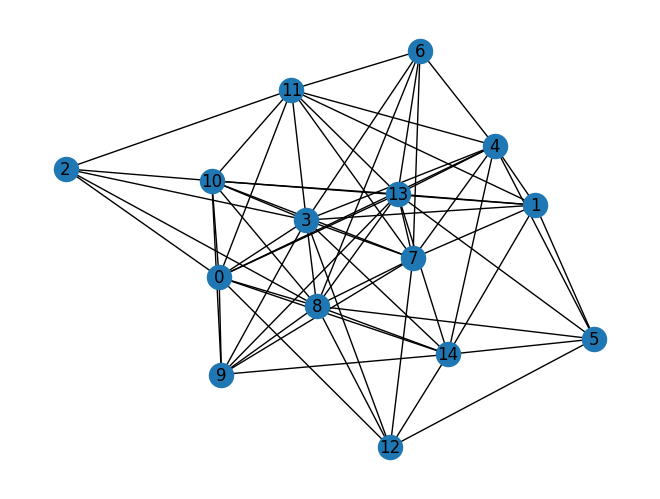

In [1]:
# Przykład grafu losowego na 15 wierzchołkach
import numpy as np
import networkx as nx

graph = nx.erdos_renyi_graph(n=15, p=0.6, seed=42)
nx.draw(graph, with_labels=True)

   0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 energy num_oc. chain_b.
0  1  0  0  1  0  1  1  1  0  0  1  0  0  0  1  -42.0       1      0.0
1  1  0  0  1  0  1  0  1  1  0  0  1  0  0  1  -41.0       2      0.0
2  0  1  1  0  1  0  1  0  1  1  0  0  1  1  0  -41.0       1      0.0
3  1  0  0  1  0  1  0  1  1  0  0  1  0  1  1  -40.0       1 0.133333
['BINARY', 4 rows, 5 samples, 15 variables]


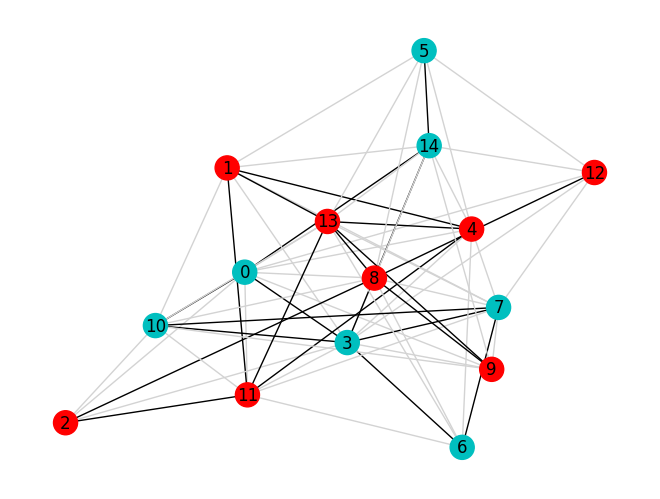

In [9]:
# QUBO Zbudujemy QUBO, jako że jest to najnaturalniejsza formulacja
# Warto wspomnieć że zarówno sample_ising() oraz sample_qubo() jako argumenty przyjmują słowniki
# Jeżeli Twoje dane są w innym formacie, należy użyć BinaryQuadraticModel z paczki dimod

import networkx as nx

from collections import defaultdict
from dwave.system import DWaveSampler, AutoEmbeddingComposite

Q = defaultdict(int)
for i, j in graph.edges:
    Q[(i,i)]+= -1
    Q[(j,j)]+= -1
    Q[(i,j)]+= 2

sampler = DWaveSampler(token=token, solver="Advantage_system4.1")

# automatycznie mapujemy nasz problem na QPU
solver = AutoEmbeddingComposite(sampler)

solution = solver.sample_qubo(Q, num_reads=5, annealing_time=10, label='Example - Maximum Cut')
print(solution)

best = solution.first.sample

# Interpretacja wyników
S0 = [node for node in graph.nodes if not best[node]]
S1 = [node for node in graph.nodes if best[node]]
cut_edges = [(u, v) for u, v in graph.edges if best[u]!=best[v]]
uncut_edges = [(u, v) for u, v in graph.edges if best[u]==best[v]]

# narysowanie najlepszego znalezionego wyniku
nx.draw(graph, node_color=["r" if i in S0 else "c" for i in list(graph.nodes)], with_labels=True, 
       edge_color=["black" if e in uncut_edges else "lightgray" for e in list(graph.edges)])

In [13]:
# Certyfikacja rozwiązania

from itertools import product
from math import inf
from dimod import BinaryQuadraticModel

qubo = BinaryQuadraticModel(Q, "BINARY")
n = qubo.num_variables

best_energy = inf
best_state = []
for state in product([0, 1], repeat=n):
    x = np.array(state)
    energy = qubo.energy(x)
    if energy < best_energy:
        best_energy = energy
        best_state = state

print("Stan podstawowy: ", best_energy)
print("Znaleziony przez D-Wave: ", solution.first.energy)



Stan podstawowy:  -42.0
Znaleziony przez D-Wave:  -42.0


# Najlepsze praktyki przy używaniu wyżarzaczy kwantowych


## Balans pomiędzy czasem wyżarzania a ilością odczytów

ako wskazówkę można przyjąć, że opłacalne jest wyrównanie czasu wyżarzania i odczytu. Zwiększenie liczby odczytów może poprawić uzyskiwane rozwiązania, jednak korzyści maleją po przekroczeniu pewnej wartości zależnej od problemu. Tak samo, zwiększenie czasu wyżarzania powyżej pewnej, zaleznej od problemu wartości, również daje malejące korzyści.

Zwiększenie zarówno czasu wyżarzania, jak i liczby odczytów podnosi prawdopodobieństwo sukcesu przy rozwiązywaniu zadanego problemu. Optymalna kombinacja czasu wyżarzania i liczby odczytów dla uzyskania najlepszego rozwiązania w ustalonym budżecie czasowym zależy od konkretnego problemu i wymaga przeprowadzenia eksperymentów.

In [ ]:
# Przykład
# WIP

## Postprocessing
Narzędzia Ocean wykonują pewne minimalne przetwarzanie końcowe. Przykładowp, przerwane łańcuchy (kiedy kubity reprezentujące daną zmienną logiczną mają różne stany) mogą zostać rozstrzygnięte poprzez głosowanie większościowe: Ocean przypisuje wartość zmiennej na podstawie stanu zwróconego przez większość kubitów w łańcuchu. 

Często możliwe jest poprawienie wyników uzyskanych z wyżarzacha kwantowego niewielkim kosztem przez zastosowanie postprocessingu.

Pakiet dwave-samplers udostępnia implementację solvera bazującego na metodzie gradientu prostego `SteepestDescentSolver`. W tym przykładzie ten klasyczny algorytm jest uruchamiany z próbkami uzyskanymi z QPU, aby znaleźć minima w otoczeniu tych próbek.


Mediana energii: 
Samo QPU: -48468.0
Postprocessing: -48513.0


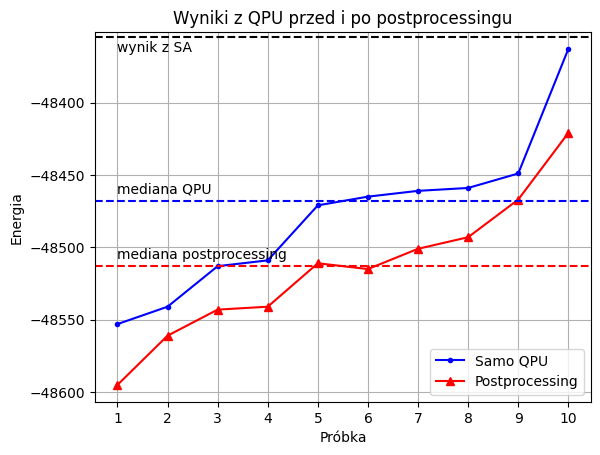

In [16]:
# Przykład
# TODO: zrób to bardziej elegancko
from dwave.system import DWaveSampler
from dwave.samplers import SteepestDescentSolver, SimulatedAnnealingSampler
import matplotlib.pyplot as plt    
import numpy as np

rng = np.random.default_rng(seed=42)

# Tworzymy problem wykorzystując wszystkie qubity i celowo dajemy siłę couplingów z poza naturalnego zasięgu
sampler = DWaveSampler(token=token, solver="Advantage_system4.1")
h = {v: 0.0 for v in sampler.nodelist}
J = {tuple(c): rng.choice(list(range(-5, 6))) for c in sampler.edgelist}

solver_greedy = SteepestDescentSolver()

sampleset_qpu = sampler.sample_ising(h, J, 
                                     num_reads=10, 
                                     label='Przyklad - Postprocessing')
# Postprocessing
sampleset_pp = solver_greedy.sample_ising(h, J, initial_states=sampleset_qpu)

mediana_qpu = np.median(sampleset_qpu.record.energy)
mediana_pp = np.median(sampleset_pp.record.energy)

# Certyfikacja
sa_sampler = SimulatedAnnealingSampler()
sampleset_sa = sa_sampler.sample_ising(h, J, num_reads=100)

sa_energy = sampleset_sa.first.energy


print("Mediana energii: ")
print(f"Samo QPU: {mediana_qpu}")
print(f"Postprocessing: {mediana_pp}")



plt.plot(list(range(1, 11)), sampleset_qpu.record.energy, 'b.-')
plt.plot(list(range(1, 11)), sampleset_pp.record.energy, 'r^-') 

plt.xticks(list(range(1, 11)))
plt.xlabel("Próbka")    
plt.ylabel("Energia")
plt.title("Wyniki z QPU przed i po postprocessingu")
plt.grid()
plt.axhline(mediana_qpu, linestyle="--", color="blue")
plt.axhline(mediana_pp, linestyle="--", color="red")
plt.axhline(sa_energy, linestyle="--", color="black")

plt.text(1, mediana_qpu+5, "mediana QPU", fontsize=10, color='black')
plt.text(1, mediana_pp+5, "mediana postprocessing", fontsize=10, color='black')
plt.text(1, sa_energy-10, "wynik z SA", fontsize=10, color='black')

plt.legend(['Samo QPU', 'Postprocessing'])  
plt.show()    

## Harmonogram wyżarzania

Harmonogram wyżarzania w maszynach DWave pozwala nam regulować prędkość z jaką zachodzą zmiany w parametrze $s$

### Pauza

Warto pauzować w okolicy QCP

WIP


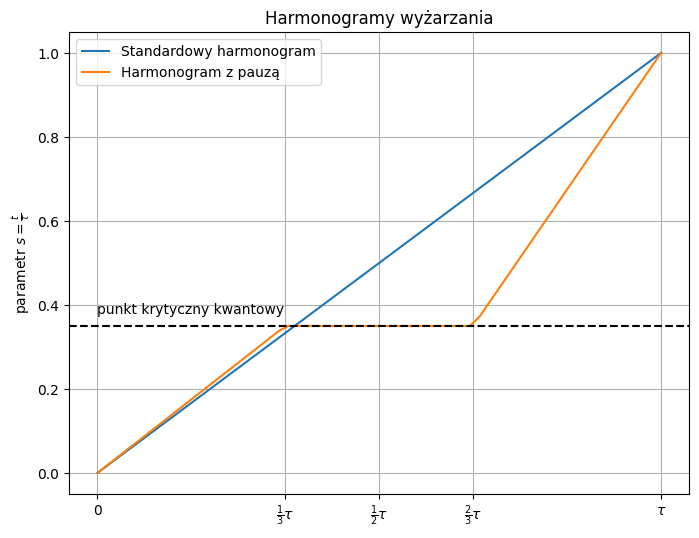

In [1]:
# Harmonogram wyżarzania z Pauzą

import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(0, 1, num=60)
y_lin = x
QCP = 0.35
y_pause = np.where(x <= 1/3, 1.05*x, 
                   np.where(x <= 2/3, QCP, 1.95*x-0.95))

plt.figure(figsize=(8,6))
plt.plot(x, y_lin, label="Standardowy harmonogram")
plt.plot(x, y_pause, label="Harmonogram z pauzą")


plt.title("Harmonogramy wyżarzania")
plt.ylabel(r"parametr $s=\frac{t}{\tau}$")
plt.xticks([0, 1/3, 1/2, 2/3, 1], labels=["0", r"$\frac{1}{3} \tau$", r"$\frac{1}{2} \tau$", r"$\frac{2}{3} \tau$", r"$\tau$"])
plt.grid()
plt.axhline(QCP, linestyle="--", color="black")
plt.text(0, QCP + 0.03, "punkt krytyczny kwantowy")
plt.legend()
plt.show()